In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ForecastFrontiers/Online Retail

/content/drive/MyDrive/ForecastFrontiers/Online Retail


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

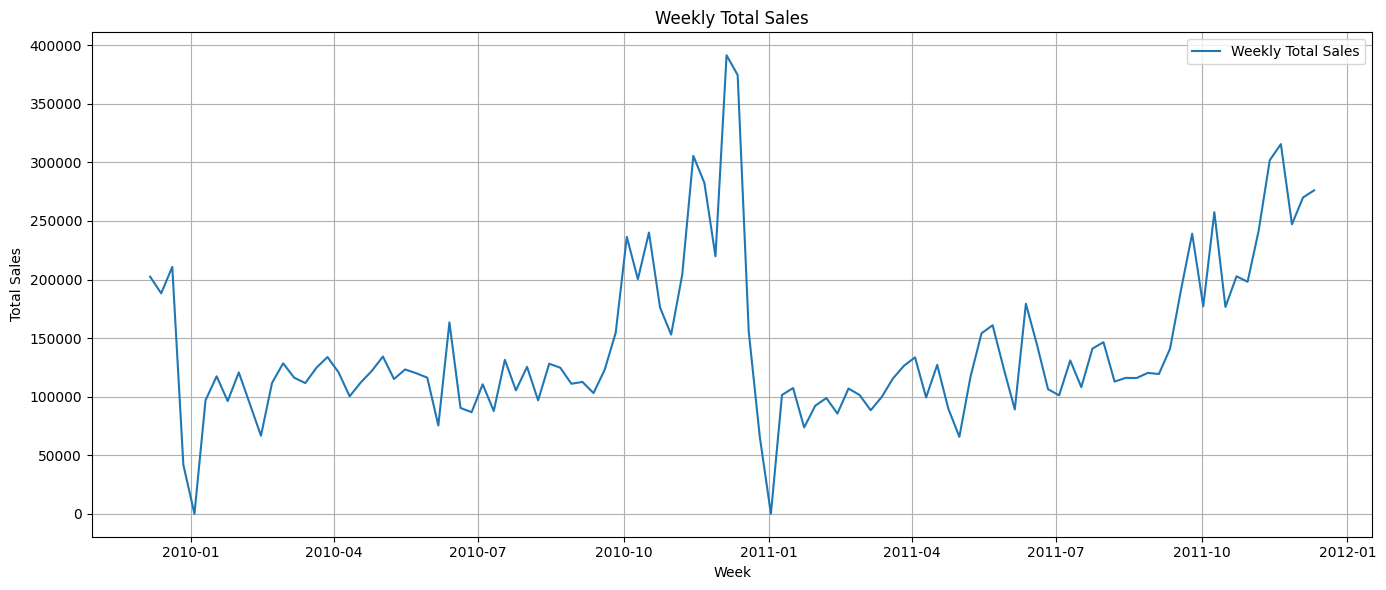

In [ ]:
# Step 1: Read data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]
df.set_index("InvoiceDate", inplace=True)

# Step 2: Aggregate by week
weekly_sales = df["Sales"].resample("W").sum()

# Step 3: Plot
plt.figure(figsize=(14, 6))
plt.plot(weekly_sales.index, weekly_sales.values, label="Weekly Total Sales", color="tab:blue")
plt.title("Weekly Total Sales")
plt.xlabel("Week")
plt.ylabel("Total Sales")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

## **overall 22.32%**

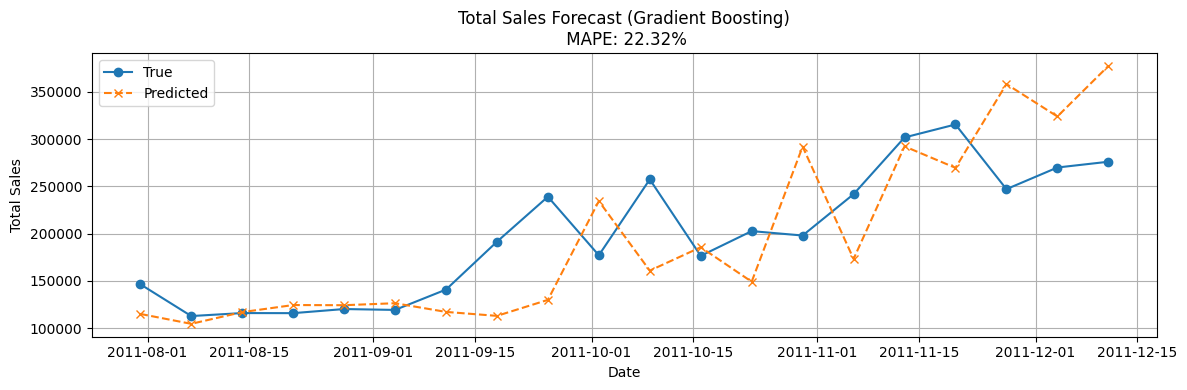

MAPE on total sales: 22.32%


In [ ]:
# Step 1: Load data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]
df.set_index("InvoiceDate", inplace=True)

# Step 2: Aggregate by week
weekly_sales = df.groupby(pd.Grouper(freq="W"))["Sales"].sum().reset_index()
weekly_sales.columns = ["ds", "y"]

# Step 3: Create features
n_lags = 7

for lag in range(1, n_lags + 1):
    weekly_sales[f"lag_{lag}"] = weekly_sales["y"].shift(lag)

weekly_sales["dayofweek"] = weekly_sales["ds"].dt.dayofweek
weekly_sales["month"] = weekly_sales["ds"].dt.month
weekly_sales["day"] = weekly_sales["ds"].dt.day

weekly_sales.dropna(inplace=True)
weekly_sales.reset_index(drop=True, inplace=True)

# Step 4: Split train/test
split_idx = int(len(weekly_sales) * 0.8)
train_df = weekly_sales.iloc[:split_idx]
test_df = weekly_sales.iloc[split_idx:]

X_train = train_df.drop(columns=["ds", "y"])
y_train = train_df["y"]
X_test = test_df.drop(columns=["ds", "y"])
y_test = test_df["y"]
test_dates = test_df["ds"]

# Step 5: Train
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Step 6: MAPE
score = mape(y_test, y_pred)

plt.figure(figsize=(12, 4))
plt.plot(test_dates, y_test.values, label="True", marker='o')
plt.plot(test_dates, y_pred, label="Predicted", linestyle='--', marker='x')
plt.title(f"Total Sales Forecast (Gradient Boosting)\n MAPE: {score:.2f}%")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 7: Summary
print(f"MAPE on total sales: {score:.2f}%")

# Fine-tune = False

## Agglomerative (k=5)

In [ ]:
# Step 1: Load data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]
df.set_index("InvoiceDate", inplace=True)

product_clusters = pd.read_csv("product_cluster_labels_a5.csv", index_col=0)

weekly_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Step 2: Split train / test
split_date = weekly_sales.index[int(len(weekly_sales) * 0.8)]
train_sales = weekly_sales.loc[:split_date]
test_sales = weekly_sales.loc[split_date:]

# Step 3: Group new product (KNN）
known_products = product_clusters.index
unknown_products = [p for p in test_sales.columns if p not in known_products]

scaler = StandardScaler()
X_known = scaler.fit_transform(train_sales[known_products].T)
y_known = product_clusters.loc[known_products]["cluster"]

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_known, y_known)

if unknown_products:
    X_unknown = scaler.transform(test_sales[unknown_products].T)
    predicted_clusters = knn.predict(X_unknown)
    predicted_df = pd.DataFrame({"StockCode": unknown_products, "cluster": predicted_clusters}).set_index("StockCode")
    all_clusters = pd.concat([product_clusters, predicted_df])
else:
    all_clusters = product_clusters.copy()

# Step 4: Clustering
train_cluster_series = train_sales.T.join(all_clusters).groupby("cluster").sum().T
test_cluster_series = test_sales.T.join(all_clusters).groupby("cluster").sum().T

n_lags = 7
results = {}

for cluster_id in train_cluster_series.columns:
    print(f"\n Building GB model for Cluster {cluster_id+1}")

    full_series = pd.concat([train_cluster_series[cluster_id], test_cluster_series[cluster_id]])
    full_df = pd.DataFrame({
        "ds": full_series.index,
        "y": full_series.values
    })

    # Lag feature
    for lag in range(1, n_lags + 1):
        full_df[f"lag_{lag}"] = full_df["y"].shift(lag)

    # Date feature
    full_df["dayofweek"] = full_df["ds"].dt.dayofweek
    full_df["month"] = full_df["ds"].dt.month
    full_df["day"] = full_df["ds"].dt.day

    full_df.dropna(inplace=True)
    full_df.reset_index(drop=True, inplace=True)

    train_len = len(train_cluster_series) - n_lags
    train_df = full_df.iloc[:train_len]
    test_df = full_df.iloc[train_len:]

    X_train = train_df.drop(columns=["ds", "y"])
    y_train = train_df["y"]
    X_test = test_df.drop(columns=["ds", "y"])
    y_test = test_df["y"]
    test_dates = test_df["ds"]

    # Train
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # MAPE
    score = mape(y_test, y_pred)

    results[cluster_id] = {
        "model": model,
        "mape": score,
        "true": y_test.values,
        "pred": y_pred,
        "dates": test_dates.values
    }

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, y_test.values, label="True", marker='o')
    plt.plot(test_dates, y_pred, label="Predicted", linestyle='--', marker='x')
    plt.title(f"Cluster {cluster_id+1} - GB Forecast (MAPE: {score:.2f}%)")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 5: Summary
mape_summary = pd.DataFrame({k: v["mape"] for k, v in results.items()}, index=["MAPE (%)"]).T
print("Cluster-wise Forecasting MAPE (Gradient Boosting):")
print(mape_summary)

all_y_true = []
all_y_pred = []

for result in results.values():
    all_y_true.extend(result["true"])
    all_y_pred.extend(result["pred"])

global_mape = mape(all_y_true, all_y_pred)
print(f"Total MAPE (Gradient Boosting): {global_mape:.2f}%")

## Agglomerative (k=2)

In [ ]:
# Step 1: Load data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]
df.set_index("InvoiceDate", inplace=True)

product_clusters = pd.read_csv("product_cluster_labels_a2.csv", index_col=0)

weekly_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Step 2: Split train / test
split_date = weekly_sales.index[int(len(weekly_sales) * 0.8)]
train_sales = weekly_sales.loc[:split_date]
test_sales = weekly_sales.loc[split_date:]

# Step 3: Group new product (KNN）
known_products = product_clusters.index
unknown_products = [p for p in test_sales.columns if p not in known_products]

scaler = StandardScaler()
X_known = scaler.fit_transform(train_sales[known_products].T)
y_known = product_clusters.loc[known_products]["cluster"]

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_known, y_known)

if unknown_products:
    X_unknown = scaler.transform(test_sales[unknown_products].T)
    predicted_clusters = knn.predict(X_unknown)
    predicted_df = pd.DataFrame({"StockCode": unknown_products, "cluster": predicted_clusters}).set_index("StockCode")
    all_clusters = pd.concat([product_clusters, predicted_df])
else:
    all_clusters = product_clusters.copy()

# Step 4: Clustering
train_cluster_series = train_sales.T.join(all_clusters).groupby("cluster").sum().T
test_cluster_series = test_sales.T.join(all_clusters).groupby("cluster").sum().T

n_lags = 7
results = {}

for cluster_id in train_cluster_series.columns:
    print(f"\n Building GB model for Cluster {cluster_id+1}")

    full_series = pd.concat([train_cluster_series[cluster_id], test_cluster_series[cluster_id]])
    full_df = pd.DataFrame({
        "ds": full_series.index,
        "y": full_series.values
    })

    # Lag feature
    for lag in range(1, n_lags + 1):
        full_df[f"lag_{lag}"] = full_df["y"].shift(lag)

    # Date feature
    full_df["dayofweek"] = full_df["ds"].dt.dayofweek
    full_df["month"] = full_df["ds"].dt.month
    full_df["day"] = full_df["ds"].dt.day

    full_df.dropna(inplace=True)
    full_df.reset_index(drop=True, inplace=True)

    train_len = len(train_cluster_series) - n_lags
    train_df = full_df.iloc[:train_len]
    test_df = full_df.iloc[train_len:]

    X_train = train_df.drop(columns=["ds", "y"])
    y_train = train_df["y"]
    X_test = test_df.drop(columns=["ds", "y"])
    y_test = test_df["y"]
    test_dates = test_df["ds"]

    # Train
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # MAPE
    score = mape(y_test, y_pred)

    results[cluster_id] = {
        "model": model,
        "mape": score,
        "true": y_test.values,
        "pred": y_pred,
        "dates": test_dates.values
    }

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, y_test.values, label="True", marker='o')
    plt.plot(test_dates, y_pred, label="Predicted", linestyle='--', marker='x')
    plt.title(f"Cluster {cluster_id+1} - GB Forecast (MAPE: {score:.2f}%)")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 5: Summary
mape_summary = pd.DataFrame({k: v["mape"] for k, v in results.items()}, index=["MAPE (%)"]).T
print("Cluster-wise Forecasting MAPE (Gradient Boosting):")
print(mape_summary)

all_y_true = []
all_y_pred = []

for result in results.values():
    all_y_true.extend(result["true"])
    all_y_pred.extend(result["pred"])

global_mape = mape(all_y_true, all_y_pred)
print(f"Total MAPE (Gradient Boosting): {global_mape:.2f}%")

##  Kmeans (k=2) - **best result: 19.49%**


 Building GB model for Cluster 1


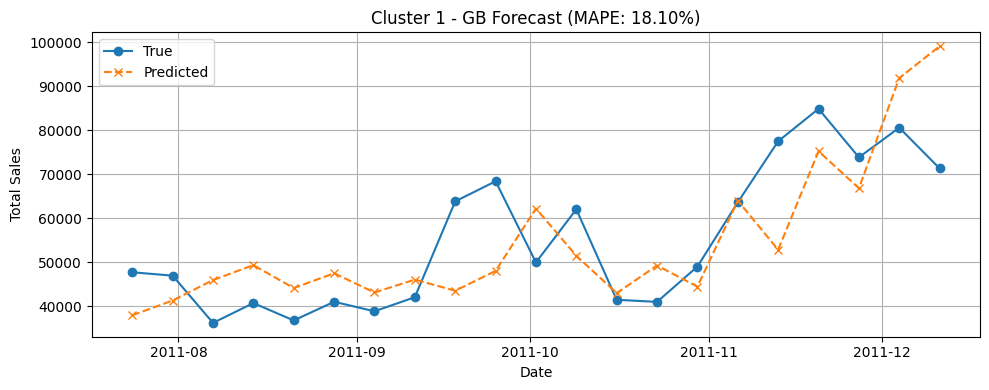


 Building GB model for Cluster 2


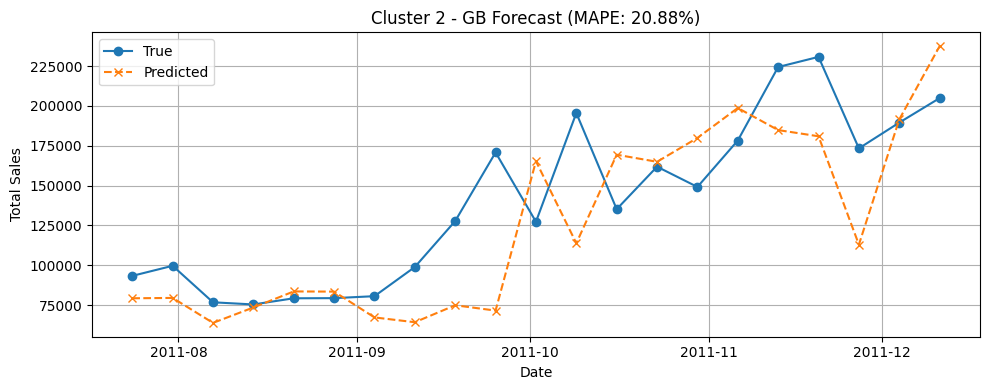

Cluster-wise Forecasting MAPE (Gradient Boosting):
    MAPE (%)
0  18.099796
1  20.880800
Total MAPE (Gradient Boosting): 19.49%


In [ ]:
# Step 1: Load data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]
df.set_index("InvoiceDate", inplace=True)

product_clusters = pd.read_csv("product_cluster_labels_k2.csv", index_col=0)

weekly_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Step 2: Split train / test
split_date = weekly_sales.index[int(len(weekly_sales) * 0.8)]
train_sales = weekly_sales.loc[:split_date]
test_sales = weekly_sales.loc[split_date:]

# Step 3: Group new product (KNN）
known_products = product_clusters.index
unknown_products = [p for p in test_sales.columns if p not in known_products]

scaler = StandardScaler()
X_known = scaler.fit_transform(train_sales[known_products].T)
y_known = product_clusters.loc[known_products]["cluster"]

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_known, y_known)

if unknown_products:
    X_unknown = scaler.transform(test_sales[unknown_products].T)
    predicted_clusters = knn.predict(X_unknown)
    predicted_df = pd.DataFrame({"StockCode": unknown_products, "cluster": predicted_clusters}).set_index("StockCode")
    all_clusters = pd.concat([product_clusters, predicted_df])
else:
    all_clusters = product_clusters.copy()

# Step 4: Clustering
train_cluster_series = train_sales.T.join(all_clusters).groupby("cluster").sum().T
test_cluster_series = test_sales.T.join(all_clusters).groupby("cluster").sum().T

n_lags = 7
results = {}

for cluster_id in train_cluster_series.columns:
    print(f"\n Building GB model for Cluster {cluster_id+1}")

    full_series = pd.concat([train_cluster_series[cluster_id], test_cluster_series[cluster_id]])
    full_df = pd.DataFrame({
        "ds": full_series.index,
        "y": full_series.values
    })

    # Lag feature
    for lag in range(1, n_lags + 1):
        full_df[f"lag_{lag}"] = full_df["y"].shift(lag)

    # Date feature
    full_df["dayofweek"] = full_df["ds"].dt.dayofweek
    full_df["month"] = full_df["ds"].dt.month
    full_df["day"] = full_df["ds"].dt.day

    full_df.dropna(inplace=True)
    full_df.reset_index(drop=True, inplace=True)

    train_len = len(train_cluster_series) - n_lags
    train_df = full_df.iloc[:train_len]
    test_df = full_df.iloc[train_len:]

    X_train = train_df.drop(columns=["ds", "y"])
    y_train = train_df["y"]
    X_test = test_df.drop(columns=["ds", "y"])
    y_test = test_df["y"]
    test_dates = test_df["ds"]

    # Train
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # MAPE
    score = mape(y_test, y_pred)

    results[cluster_id] = {
        "model": model,
        "mape": score,
        "true": y_test.values,
        "pred": y_pred,
        "dates": test_dates.values
    }

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, y_test.values, label="True", marker='o')
    plt.plot(test_dates, y_pred, label="Predicted", linestyle='--', marker='x')
    plt.title(f"Cluster {cluster_id+1} - GB Forecast (MAPE: {score:.2f}%)")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 5: Summary
mape_summary = pd.DataFrame({k: v["mape"] for k, v in results.items()}, index=["MAPE (%)"]).T
print("Cluster-wise Forecasting MAPE (Gradient Boosting):")
print(mape_summary)

all_y_true = []
all_y_pred = []

for result in results.values():
    all_y_true.extend(result["true"])
    all_y_pred.extend(result["pred"])

global_mape = mape(all_y_true, all_y_pred)
print(f"Total MAPE (Gradient Boosting): {global_mape:.2f}%")

## Kmeans (k=5)

In [ ]:
# Step 1: Load data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]
df.set_index("InvoiceDate", inplace=True)

product_clusters = pd.read_csv("product_cluster_labels_k5.csv", index_col=0)

weekly_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Step 2: Split train / test
split_date = weekly_sales.index[int(len(weekly_sales) * 0.8)]
train_sales = weekly_sales.loc[:split_date]
test_sales = weekly_sales.loc[split_date:]

# Step 3: Group new product (KNN）
known_products = product_clusters.index
unknown_products = [p for p in test_sales.columns if p not in known_products]

scaler = StandardScaler()
X_known = scaler.fit_transform(train_sales[known_products].T)
y_known = product_clusters.loc[known_products]["cluster"]

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_known, y_known)

if unknown_products:
    X_unknown = scaler.transform(test_sales[unknown_products].T)
    predicted_clusters = knn.predict(X_unknown)
    predicted_df = pd.DataFrame({"StockCode": unknown_products, "cluster": predicted_clusters}).set_index("StockCode")
    all_clusters = pd.concat([product_clusters, predicted_df])
else:
    all_clusters = product_clusters.copy()

# Step 4: Clustering
train_cluster_series = train_sales.T.join(all_clusters).groupby("cluster").sum().T
test_cluster_series = test_sales.T.join(all_clusters).groupby("cluster").sum().T

n_lags = 7
results = {}

for cluster_id in train_cluster_series.columns:
    print(f"\n Building GB model for Cluster {cluster_id+1}")

    full_series = pd.concat([train_cluster_series[cluster_id], test_cluster_series[cluster_id]])
    full_df = pd.DataFrame({
        "ds": full_series.index,
        "y": full_series.values
    })

    # Lag feature
    for lag in range(1, n_lags + 1):
        full_df[f"lag_{lag}"] = full_df["y"].shift(lag)

    # Date feature
    full_df["dayofweek"] = full_df["ds"].dt.dayofweek
    full_df["month"] = full_df["ds"].dt.month
    full_df["day"] = full_df["ds"].dt.day

    full_df.dropna(inplace=True)
    full_df.reset_index(drop=True, inplace=True)

    train_len = len(train_cluster_series) - n_lags
    train_df = full_df.iloc[:train_len]
    test_df = full_df.iloc[train_len:]

    X_train = train_df.drop(columns=["ds", "y"])
    y_train = train_df["y"]
    X_test = test_df.drop(columns=["ds", "y"])
    y_test = test_df["y"]
    test_dates = test_df["ds"]

    # Train
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # MAPE
    score = mape(y_test, y_pred)

    results[cluster_id] = {
        "model": model,
        "mape": score,
        "true": y_test.values,
        "pred": y_pred,
        "dates": test_dates.values
    }

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, y_test.values, label="True", marker='o')
    plt.plot(test_dates, y_pred, label="Predicted", linestyle='--', marker='x')
    plt.title(f"Cluster {cluster_id+1} - GB Forecast (MAPE: {score:.2f}%)")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 5: Summary
mape_summary = pd.DataFrame({k: v["mape"] for k, v in results.items()}, index=["MAPE (%)"]).T
print("Cluster-wise Forecasting MAPE (Gradient Boosting):")
print(mape_summary)

all_y_true = []
all_y_pred = []

for result in results.values():
    all_y_true.extend(result["true"])
    all_y_pred.extend(result["pred"])

global_mape = mape(all_y_true, all_y_pred)
print(f"Total MAPE (Gradient Boosting): {global_mape:.2f}%")

## Description Length

In [ ]:
# Step 1: Load data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]
df["Description"] = df["Description"].astype(str)
df["DescriptionLength"] = df["Description"].apply(len)
df["IsLongDescription"] = df["DescriptionLength"] > 23

product_labels = df.groupby("StockCode")["IsLongDescription"].first().to_frame()

df.set_index("InvoiceDate", inplace=True)
weekly_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Step 2: Split train/test
split_date = weekly_sales.index[int(len(weekly_sales) * 0.8)]
train_sales = weekly_sales.loc[:split_date]
test_sales = weekly_sales.loc[split_date:]

train_labels = product_labels.loc[train_sales.columns]
long_products = train_labels[train_labels["IsLongDescription"]].index
short_products = train_labels[~train_labels["IsLongDescription"]].index

train_long = train_sales[long_products].sum(axis=1)
train_short = train_sales[short_products].sum(axis=1)
test_long = test_sales[long_products].sum(axis=1)
test_short = test_sales[short_products].sum(axis=1)

# Step 3: Train function
def train_predict_gb(series_train, series_test, label):
    n_lags = 7
    full_series = pd.concat([series_train, series_test])
    df_all = pd.DataFrame({"ds": full_series.index, "y": full_series.values})

    for lag in range(1, n_lags + 1):
        df_all[f"lag_{lag}"] = df_all["y"].shift(lag)

    df_all["dayofweek"] = df_all["ds"].dt.dayofweek
    df_all["month"] = df_all["ds"].dt.month
    df_all["day"] = df_all["ds"].dt.day

    df_all.dropna(inplace=True)
    df_all.reset_index(drop=True, inplace=True)

    train_len = len(series_train) - n_lags
    train_df = df_all.iloc[:train_len]
    test_df = df_all.iloc[train_len:]

    X_train = train_df.drop(columns=["ds", "y"])
    y_train = train_df["y"]
    X_test = test_df.drop(columns=["ds", "y"])
    y_test = test_df["y"]
    test_dates = test_df["ds"]

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = mape(y_test, y_pred)

    plt.figure(figsize=(12, 4))
    plt.plot(test_dates, y_test.values, label="True", marker='o')
    plt.plot(test_dates, y_pred, label="Predicted", linestyle='--', marker='x')
    plt.title(f"{label} Description Products - Sales Forecast\n MAPE: {score:.2f}%")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return y_test.values, y_pred, score

# Step 4: Train
print("Predicting Long Description Products")
y_true_long, y_pred_long, long_mape = train_predict_gb(train_long, test_long, label="Long")

print("Predicting Short Description Products")
y_true_short, y_pred_short, short_mape = train_predict_gb(train_short, test_short, label="Short")

# Step 5: Summary
total_y_true = y_true_long + y_true_short
total_y_pred = y_pred_long + y_pred_short
global_mape = mape(total_y_true, total_y_pred)
print("\n Summary:")
print(f"Long Description MAPE: {long_mape:.2f}%")
print(f"Short Description MAPE: {short_mape:.2f}%")
print(f"Overall Combined MAPE: {global_mape:.2f}%")

## Kmeans (k=2) & Description Length

In [ ]:
# Step 1: Load data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]
df["Description"] = df["Description"].astype(str)
df["DescriptionLength"] = df["Description"].apply(len)
df["IsLongDescription"] = df["DescriptionLength"] > 23

product_clusters = pd.read_csv("product_cluster_labels_k2.csv", index_col=0)
product_labels = pd.concat([product_clusters, df.groupby("StockCode")["IsLongDescription"].first()], axis=1)

df.set_index("InvoiceDate", inplace=True)
weekly_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Step 2: Split train/test
split_date = daily_sales.index[int(len(daily_sales) * 0.8)]
train_sales = daily_sales.loc[:split_date]
test_sales = daily_sales.loc[split_date:]

product_labels["group"] = product_labels.apply(
    lambda row: f"Cluster{row['cluster']}_Long" if row["IsLongDescription"] else f"Cluster{row['cluster']}_Short",
    axis=1
)

# Step 3: Train function
def train_predict_gb(series_train, series_test, label):
    n_lags = 7
    full_series = pd.concat([series_train, series_test])
    df_all = pd.DataFrame({"ds": full_series.index, "y": full_series.values})

    for lag in range(1, n_lags + 1):
        df_all[f"lag_{lag}"] = df_all["y"].shift(lag)
    df_all["dayofweek"] = df_all["ds"].dt.dayofweek
    df_all["month"] = df_all["ds"].dt.month
    df_all["day"] = df_all["ds"].dt.day

    df_all.dropna(inplace=True)
    df_all.reset_index(drop=True, inplace=True)

    train_len = len(series_train) - n_lags
    train_df = df_all.iloc[:train_len]
    test_df = df_all.iloc[train_len:]

    X_train = train_df.drop(columns=["ds", "y"])
    y_train = train_df["y"]
    X_test = test_df.drop(columns=["ds", "y"])
    y_test = test_df["y"]
    test_dates = test_df["ds"]

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = mape(y_test, y_pred)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(test_dates, y_test.values, label="True", marker='o')
    plt.plot(test_dates, y_pred, label="Predicted", linestyle='--', marker='x')
    plt.title(f"{label} - Sales Forecast (MAPE: {score:.2f}%)")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return y_test.values, y_pred, score

# Step 4: Train
all_y_true = []
all_y_pred = []
group_mape = {}

for group_name in product_labels["group"].unique():
    product_ids = product_labels[product_labels["group"] == group_name].index
    train_series = train_sales[product_ids].sum(axis=1)
    test_series = test_sales[product_ids].sum(axis=1)
    print(f"\n Modeling for {group_name}")
    y_true, y_pred, score = train_predict_gb(train_series, test_series, label=group_name)

    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)

    group_mape[group_name] = score

# Step 5: Summary
print("\n Summary of MAPE by Group:")
for group, score in group_mape.items():
    print(f"{group}: {score:.2f}%")

total_mape = mape(all_y_true, all_y_pred)
print(f"Overall Combined MAPE: {total_mape:.2f}%")

# Fine-tune = True - best result: 17.97%

Evaluating config: {'n_estimators': 60, 'learning_rate': 0.1, 'max_depth': 2}
Evaluating config: {'n_estimators': 60, 'learning_rate': 0.1, 'max_depth': 3}
Evaluating config: {'n_estimators': 60, 'learning_rate': 0.1, 'max_depth': 5}
Evaluating config: {'n_estimators': 60, 'learning_rate': 0.06, 'max_depth': 2}
Evaluating config: {'n_estimators': 60, 'learning_rate': 0.06, 'max_depth': 3}
Evaluating config: {'n_estimators': 60, 'learning_rate': 0.06, 'max_depth': 5}
Evaluating config: {'n_estimators': 60, 'learning_rate': 0.03, 'max_depth': 2}
Evaluating config: {'n_estimators': 60, 'learning_rate': 0.03, 'max_depth': 3}
Evaluating config: {'n_estimators': 60, 'learning_rate': 0.03, 'max_depth': 5}
Evaluating config: {'n_estimators': 80, 'learning_rate': 0.1, 'max_depth': 2}
Evaluating config: {'n_estimators': 80, 'learning_rate': 0.1, 'max_depth': 3}
Evaluating config: {'n_estimators': 80, 'learning_rate': 0.1, 'max_depth': 5}
Evaluating config: {'n_estimators': 80, 'learning_rate': 0

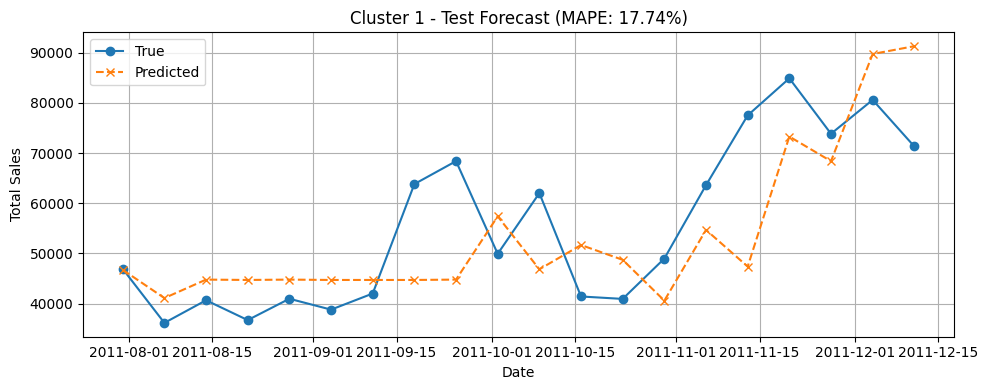

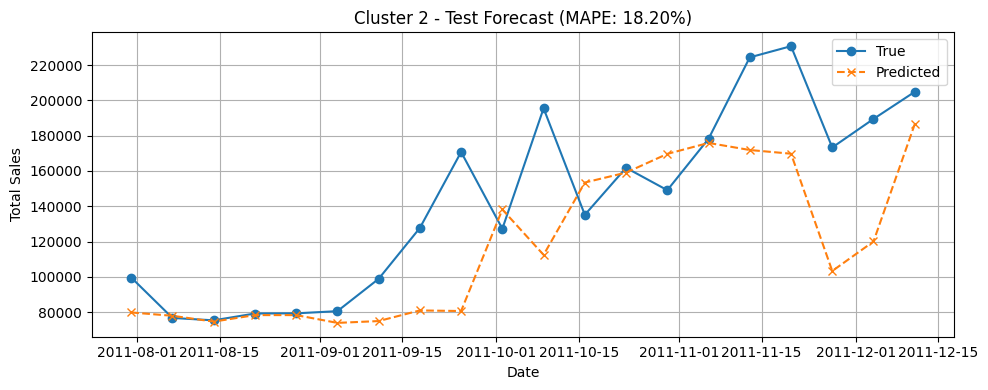

Test MAPE by Cluster:
   Test MAPE (%)
0      17.744752
1      18.196896

Total Test MAPE: 17.97%


In [ ]:
# ---------------------
# Step 1: Load data
# ---------------------
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]
df.set_index("InvoiceDate", inplace=True)

product_clusters = pd.read_csv("product_cluster_labels_k2.csv", index_col=0)

# ---------------------
# Step 2: Create weekly sales data
# ---------------------
weekly_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Split train+val / test（80/20）
split_date = weekly_sales.index[int(len(weekly_sales) * 0.8)]
trainval_sales = weekly_sales.loc[:split_date]
test_sales = weekly_sales.loc[split_date:]

# KNN for new product cluster
known_products = product_clusters.index
unknown_products = [p for p in test_sales.columns if p not in known_products]

scaler = StandardScaler()
X_known = scaler.fit_transform(trainval_sales[known_products].T)
y_known = product_clusters.loc[known_products]["cluster"]

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_known, y_known)

if unknown_products:
    X_unknown = scaler.transform(test_sales[unknown_products].T)
    predicted_clusters = knn.predict(X_unknown)
    predicted_df = pd.DataFrame({"StockCode": unknown_products, "cluster": predicted_clusters}).set_index("StockCode")
    all_clusters = pd.concat([product_clusters, predicted_df])
else:
    all_clusters = product_clusters.copy()

trainval_cluster_series = trainval_sales.T.join(all_clusters).groupby("cluster").sum().T
test_cluster_series = test_sales.T.join(all_clusters).groupby("cluster").sum().T

# ---------------------
# Step 3: MAPE function
# ---------------------
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

# ---------------------
# Step 4: Parameters grid
# ---------------------
param_grid = {
    "n_estimators": [60, 80, 120, 200],
    "learning_rate": [0.1, 0.06, 0.03],
    "max_depth": [2, 3, 5]
}
param_names = list(param_grid.keys())
param_values = list(param_grid.values())
param_combinations = list(product(*param_values))

# ---------------------
# Step 5: Parameters search
# ---------------------
tuning_results = []

for values in param_combinations:
    config = dict(zip(param_names, values))
    print(f"Evaluating config: {config}")

    cluster_val_scores = {}

    for cluster_id in trainval_cluster_series.columns:
        full_series = pd.concat([trainval_cluster_series[cluster_id], test_cluster_series[cluster_id]])
        df_all = pd.DataFrame({"ds": full_series.index, "y": full_series.values})

        for lag in range(1, 8):
            df_all[f"lag_{lag}"] = df_all["y"].shift(lag)
        df_all["dayofweek"] = df_all["ds"].dt.dayofweek
        df_all["month"] = df_all["ds"].dt.month
        df_all["day"] = df_all["ds"].dt.day
        df_all.dropna(inplace=True)
        df_all.reset_index(drop=True, inplace=True)

        total_len = len(df_all)
        train_size = int(total_len * 0.6)
        val_size = int(total_len * 0.2)

        train_df = df_all.iloc[:train_size]
        val_df = df_all.iloc[train_size:train_size + val_size]

        X_train = train_df.drop(columns=["ds", "y"])
        y_train = train_df["y"]
        X_val = val_df.drop(columns=["ds", "y"])
        y_val = val_df["y"]

        model = XGBRegressor(**config, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        val_score = mape(y_val, y_pred)
        cluster_val_scores[f"Cluster{cluster_id}"] = val_score

    global_val_score = np.mean(list(cluster_val_scores.values()))
    tuning_results.append({
        "params": config,
        **cluster_val_scores,
        "Global_Val_MAPE": global_val_score
    })

tuning_df = pd.DataFrame(tuning_results)
best_config = tuning_df.sort_values("Global_Val_MAPE").iloc[0]["params"]
print("\nBest Config:", best_config)

# ---------------------
# Step 6: Train with best configuration
# ---------------------
results = {}
n_lags = 7

for cluster_id in trainval_cluster_series.columns:
    full_series = pd.concat([trainval_cluster_series[cluster_id], test_cluster_series[cluster_id]])
    df_all = pd.DataFrame({"ds": full_series.index, "y": full_series.values})

    for lag in range(1, n_lags + 1):
        df_all[f"lag_{lag}"] = df_all["y"].shift(lag)
    df_all["dayofweek"] = df_all["ds"].dt.dayofweek
    df_all["month"] = df_all["ds"].dt.month
    df_all["day"] = df_all["ds"].dt.day

    df_all.dropna(inplace=True)
    df_all.reset_index(drop=True, inplace=True)

    total_len = len(df_all)
    trainval_size = int(total_len * 0.8)

    trainval_df = df_all.iloc[:trainval_size]
    test_df = df_all.iloc[trainval_size:]

    X_trainval = trainval_df.drop(columns=["ds", "y"])
    y_trainval = trainval_df["y"]
    X_test = test_df.drop(columns=["ds", "y"])
    y_test = test_df["y"]
    test_dates = test_df["ds"]

    model = XGBRegressor(**best_config, random_state=42)
    model.fit(X_trainval, y_trainval)
    y_pred = model.predict(X_test)

    score = mape(y_test, y_pred)

    results[cluster_id] = {
        "mape": score,
        "true": y_test.values,
        "pred": y_pred,
        "dates": test_dates.values
    }

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, y_test.values, label="True", marker='o')
    plt.plot(test_dates, y_pred, label="Predicted", linestyle='--', marker='x')
    plt.title(f"Cluster {cluster_id+1} - Test Forecast (MAPE: {score:.2f}%)")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Summary test MAPE
mape_summary = pd.DataFrame({k: v["mape"] for k, v in results.items()}, index=["Test MAPE (%)"]).T
print("Test MAPE by Cluster:")
print(mape_summary)

all_y_true = []
all_y_pred = []
for result in results.values():
    all_y_true.extend(result["true"])
    all_y_pred.extend(result["pred"])

global_test_mape = mape(all_y_true, all_y_pred)
print(f"\nTotal Test MAPE: {global_test_mape:.2f}%")

MAPE by Test Period:
period
Period I       9.828300
Period II     23.108542
Period III    20.580422
Name: abs_perc_error, dtype: float64


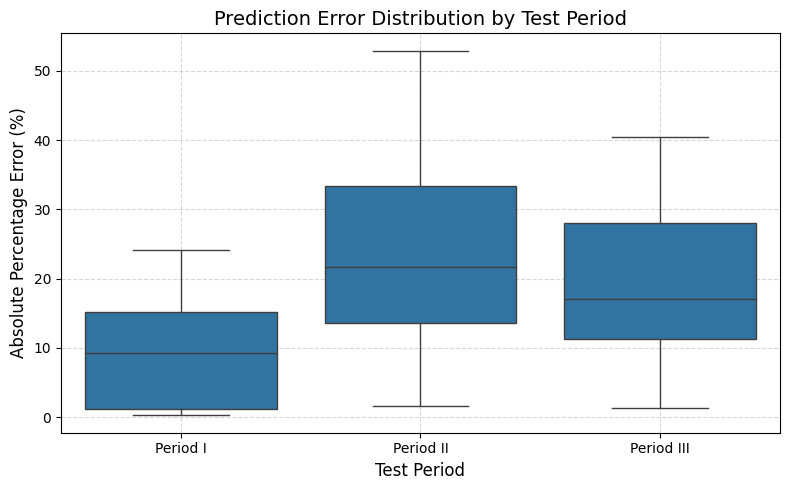

In [ ]:
# Load Results
df_all_test = []

for cid, res in results.items():
    df = pd.DataFrame({
        "cluster": cid,
        "ds": res["dates"],
        "y_true": res["true"],
        "y_pred": res["pred"]
    })
    df_all_test.append(df)

df_all_test = pd.concat(df_all_test, ignore_index=True)

df_all_test["abs_perc_error"] = np.abs(df_all_test["y_true"] - df_all_test["y_pred"]) / np.clip(np.abs(df_all_test["y_true"]), 1e-8, None) * 100

# 3 Test Period
df_all_test = df_all_test.sort_values("ds").reset_index(drop=True)
n = len(df_all_test)
split1 = n // 3
split2 = 2 * n // 3

df_all_test["period"] = "Period III"
df_all_test.loc[:split1, "period"] = "Period I"
df_all_test.loc[split1:split2, "period"] = "Period II"

# MAPE
def calc_mape(df):
    return np.mean(df)

mape_by_period = df_all_test.groupby("period")["abs_perc_error"].apply(calc_mape)
print("MAPE by Test Period:")
print(mape_by_period)

# Box Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_all_test, x="period", y="abs_perc_error")
plt.title("Prediction Error Distribution by Test Period", fontsize=14)
plt.xlabel("Test Period", fontsize=12)
plt.ylabel("Absolute Percentage Error (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

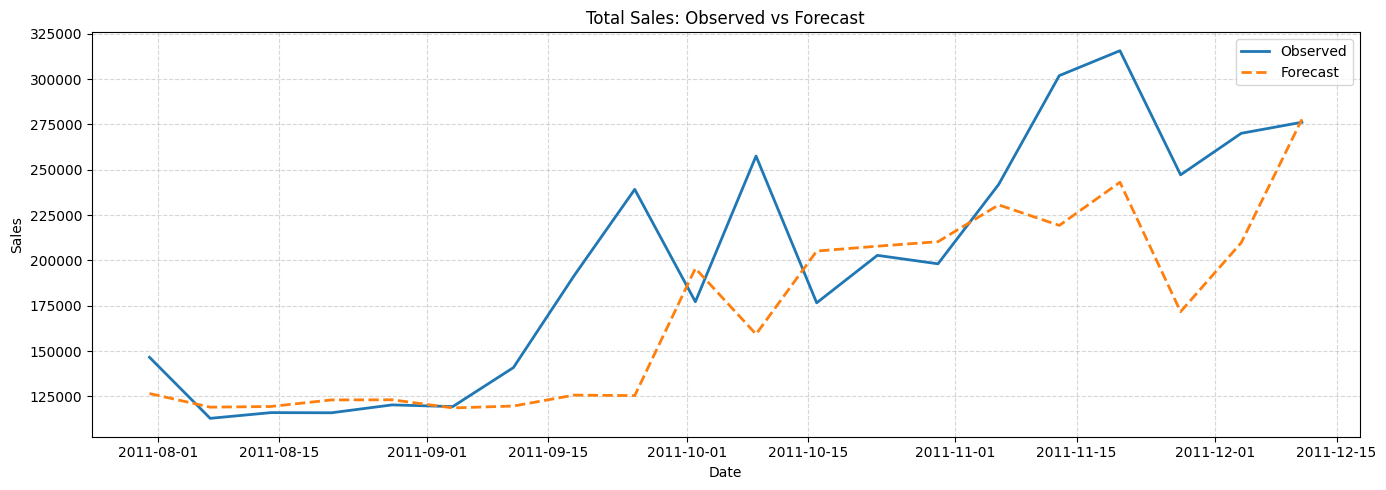

In [ ]:
df_total = df_all_test.groupby("ds")[["y_true", "y_pred"]].sum().sort_index()

plt.figure(figsize=(14, 5))
plt.plot(df_total.index, df_total["y_true"], label="Observed", color="tab:blue", linewidth=2)
plt.plot(df_total.index, df_total["y_pred"], label="Forecast", color="tab:orange", linestyle="--", linewidth=2)

plt.title("Total Sales: Observed vs Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

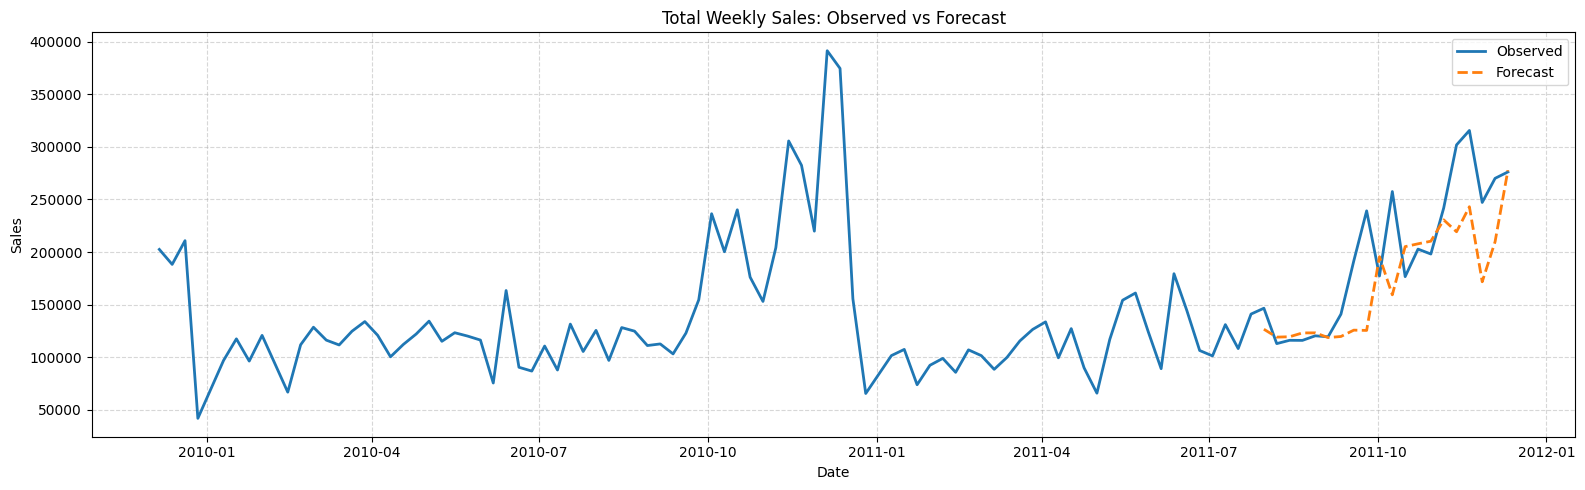

In [ ]:
# Forecast Plot
test_dates = pd.DatetimeIndex(results[0]["dates"])

y_train_all = train_cluster_series.sum(axis=1)
y_test_true = np.sum([v["true"] for v in results.values()], axis=0)
y_test_pred = np.sum([v["pred"] for v in results.values()], axis=0)

dates_all = y_train_all.index.append(test_dates)
y_true_all = np.concatenate([y_train_all.values, y_test_true])

plt.figure(figsize=(16, 5))
plt.plot(dates_all, y_true_all, label="Observed", color="C0", linewidth=2)
plt.plot(test_dates, y_test_pred, label="Forecast", color="C1", linestyle="--", linewidth=2)

plt.title("Total Weekly Sales: Observed vs Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()